In [51]:
import numpy as np
import pandas as pd
import glob
import pandas_profiling
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns



In [52]:
'''
No need to run this cell again. Use the pkl in the next cell to load in data.
'''
# Read in data
# df_list = [pd.read_csv(f, low_memory=False) for f in glob.glob('*.csv')]


# # Make year list to make a column of each year in its respective dataframe
# year_list = list(np.arange(1996,2018))


# # Make a year column 
# for index, df in enumerate(df_list):
#     df['year'] = year_list[index]

# # Concatenate all the dataframes into one dataframe
# df=pd.concat(df_list, ignore_index=True)


# # Save as pickle
# pd.to_pickle(df, 'big_ol_df.pkl')

'\nNo need to run this cell again. Use the pkl in the next cell to load in data.\n'

In [53]:
# If you need to rerun everything, start here:
df = pd.read_pickle('data/pickle_copy.pkl')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154228 entries, 0 to 7057
Data columns (total 14 columns):
INSTNM           154228 non-null object
HIGHDEG          154228 non-null int64
CONTROL          154205 non-null float64
REGION           154227 non-null float64
LOCALE           6614 non-null float64
CURROPER         7058 non-null float64
TUITFTE          133780 non-null float64
INEXPFTE         133775 non-null float64
CDR3             47815 non-null float64
LO_INC_DEBT_N    137486 non-null object
MD_INC_DEBT_N    137486 non-null object
HI_INC_DEBT_N    137486 non-null object
ICLEVEL          154205 non-null float64
year             154228 non-null int64
dtypes: float64(8), int64(2), object(4)
memory usage: 17.6+ MB


In [55]:
# Grabbing columns of interest
df_regression = df.loc[:, ['TUITFTE', 'INEXPFTE']]

In [56]:
# Checking out data set
df_regression

,TUITFTE,INEXPFTE
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [57]:
# Observing how much of our data is na
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154228 entries, 0 to 7057
Data columns (total 2 columns):
TUITFTE     133780 non-null float64
INEXPFTE    133775 non-null float64
dtypes: float64(2)
memory usage: 3.5 MB


In [58]:
# Dropping na values for regression (still have ~80k data points and we just want to practice ridge regression)
df_no_na = df_regression.dropna()

In [59]:
# Renaming columns
df_no_na.columns = ['tuition', 'instructional_exp']

In [63]:
# Dropping zeros
indices_to_drop = df_no_na[df_no_na['tuition']==0].index

In [64]:
df_no_na.drop(indices_to_drop, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
# Looking again
df_no_na

,tuition,instructional_exp
0,2998.0,3212.0
1,4030.0,10418.0
2,3068.0,3997.0
3,3955.0,5784.0
4,3254.0,3121.0
5,4065.0,5824.0
6,964.0,2242.0
7,1305.0,1637.0
8,2516.0,3404.0
9,3715.0,4622.0


In [66]:
# Performing the regression

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Create dataframes( or series) with predictors and  predicted values
# 'instructional_exp', 'fac_salary', 'pct_pell', 'tuition'
X = df_no_na[['tuition']]
y = df_no_na['instructional_exp']
    
# Scale the data using Robust Scaler
scale = PowerTransformer(method='box-cox', standardize=False)
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

# Create Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a ridge regression model
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

# Create predicted values
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

In [67]:
# Coeffiecient of determination
ridge.score(X_train, y_train)

0.010126023764811198

In [68]:
# slope
ridge.coef_

array([12881.2797416])

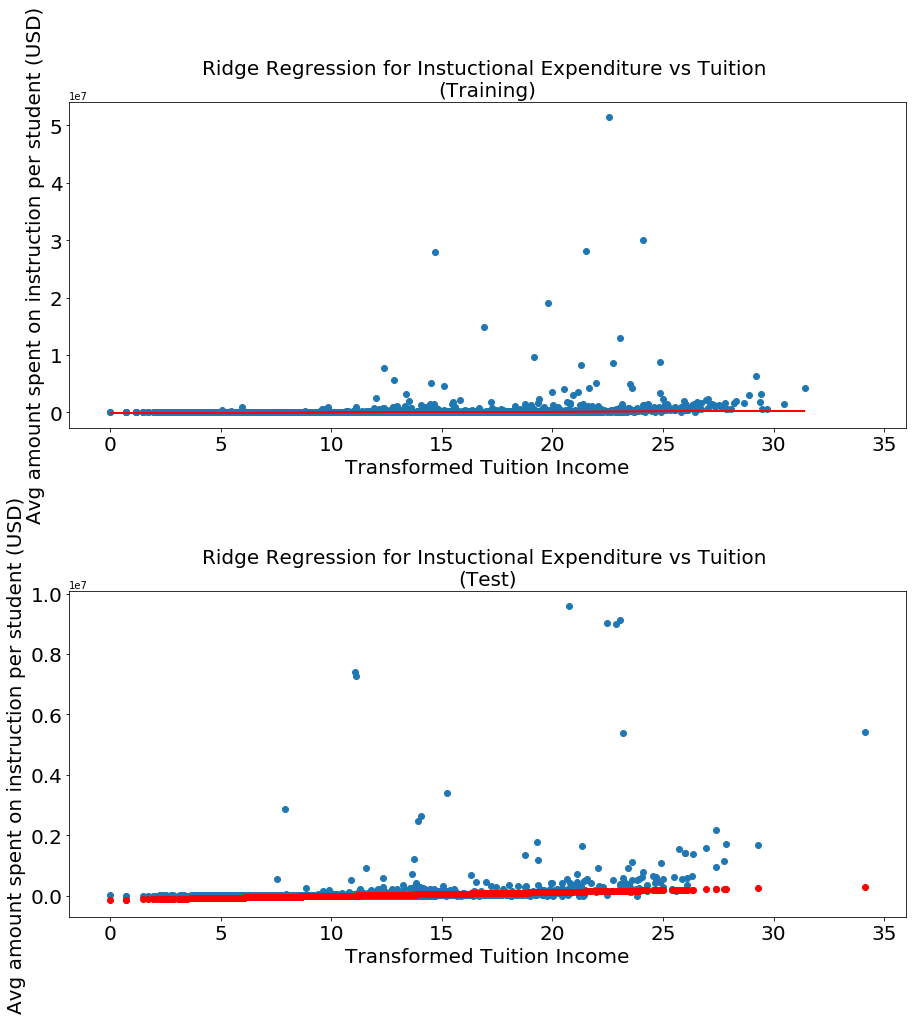

In [69]:
# Plot regression

fig = plt.figure(figsize=(15,15))


# Plotting the training data + predicitons
ax1 = fig.add_subplot(211)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Training)', fontsize=20)
# plt.text(5.5,30000,f'$R^2 = {round(ridge.score(X_train,y_train), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Avg amount spent on instruction per student (USD)', fontsize=20)
plt.scatter(X_train, y_train)
plt.plot(X_train, y_h_ridge_train, color='red')


# Plotting the testing data + predicitons
ax2 = fig.add_subplot(212, sharex=ax1)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Test)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.text(5.5,15000,f'$R^2 = {round(ridge.score(X_test,y_test), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.ylabel('Avg amount spent on instruction per student (USD)', fontsize=20)
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_h_ridge_test, color='red')


plt.subplots_adjust(hspace=0.5)
plt.savefig('instruction_vs_tuition.png')




In [70]:
# There are a lot of outliers... Trying 99th percentile...
df_no_outliers = df_no_na.copy()

In [71]:
df_no_outliers = df_no_na[(df_no_na['instructional_exp'] < df_no_na['instructional_exp'].quantile(0.99))
                         & (df_no_na['tuition'] < df_no_na['tuition'].quantile(0.99))]

In [72]:
# Redoing the regression

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Create dataframes( or series) with predictors and  predicted values
# 'instructional_exp', 'fac_salary', 'pct_pell', 'tuition'
X = df_no_outliers[['tuition']]
y = df_no_outliers['instructional_exp']
    
# Scale the data using Robust Scaler
scale = PowerTransformer(method='box-cox', standardize=False)
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

# Create Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a ridge regression model
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

# Create predicted values
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

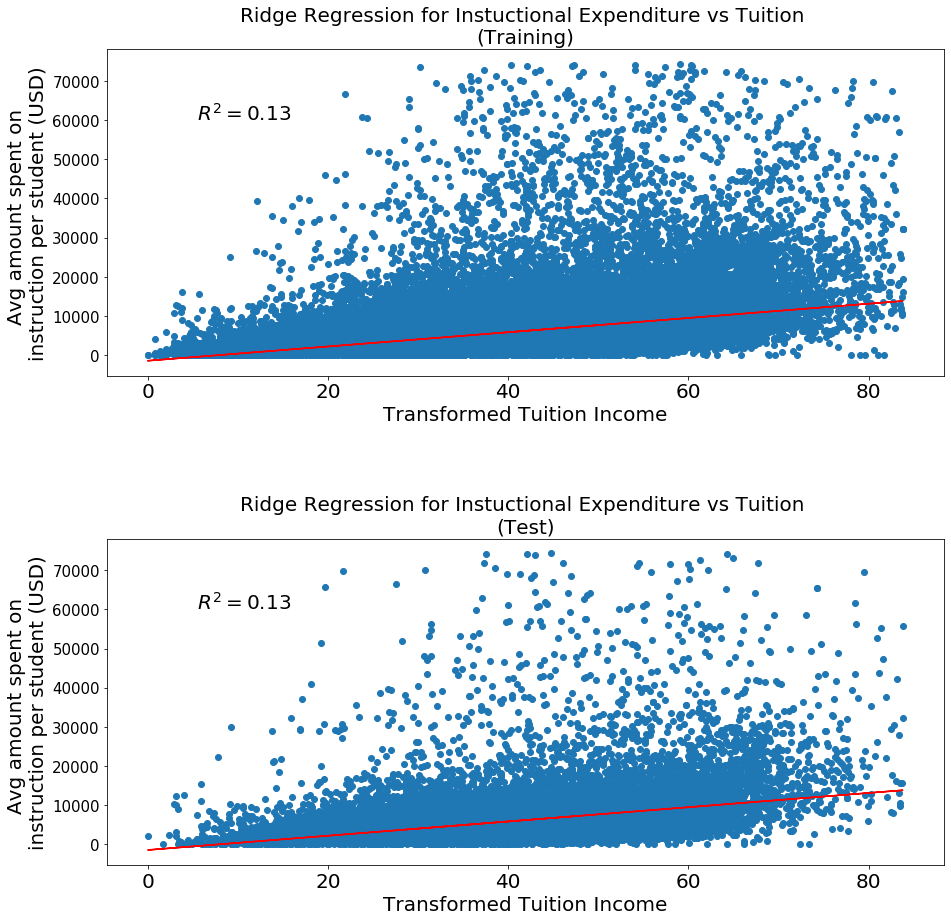

In [77]:
# And plot

fig = plt.figure(figsize=(15,15))


# Plotting the training data + predicitons
ax1 = fig.add_subplot(211)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Training)', fontsize=20)
plt.text(5.5,60000,f'$R^2 = {round(ridge.score(X_train,y_train), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Avg amount spent on \ninstruction per student (USD)', fontsize=20)
plt.scatter(X_train, y_train)
plt.plot(X_train, y_h_ridge_train, color='red')


# Plotting the testing data + predicitons
ax2 = fig.add_subplot(212, sharex=ax1)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Test)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.text(5.5,60000,f'$R^2 = {round(ridge.score(X_test,y_test), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.ylabel('Avg amount spent on \ninstruction per student (USD)', fontsize=20)
plt.scatter(X_test, y_test)
plt.plot(X_test, y_h_ridge_test, color='red')


plt.subplots_adjust(hspace=0.5)
plt.savefig('instruction_vs_tuition.png')


